In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import datetime as dt
from math import factorial

metrics_path = '../metrics/'
figure_path = 'figures/'

def get_filenames_in_folder(path):
    file_names = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.lower().endswith('.csv')]
    file_names.sort()
    return file_names

all_files = get_filenames_in_folder(metrics_path)
print(all_files)

def read_file(path):
    return pd.read_csv(path, comment='#')

if len(all_files) > 0:
    latest_data = read_file(all_files[0])
    print(latest_data.iloc[1])

GLOBAL_STYLE = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'font.size': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.axisbelow': True  # grid lines below data
}

FIGURE_SIZE = (12, 7)

LINE_STYLE = {
    "linewidth": 1.5,
    "linestyle": "-"  # solid lines
}

GRID_STYLE = {
    "visible": True,
    "linestyle": "--",
    "alpha": 0.6
}

plt.rcParams.update(GLOBAL_STYLE)

['../metrics/2025-07-31_10-12-42_metrics.csv', '../metrics/2025-08-04_13-15-09_metrics.csv', '../metrics/2025-08-04_16-11-57_metrics.csv', '../metrics/2025-08-04_16-14-45_metrics.csv', '../metrics/2025-08-04_16-15-33_metrics.csv', '../metrics/2025-08-04_16-17-37_metrics.csv']
timestamp    2025-07-31T10:08:36+00:00
field                   fragments_sent
value                              0.0
node                            node_0
Name: 1, dtype: object


[0.003   0.00475 0.0065  0.00825 0.01   ]
[41.02993774 32.00982809 27.97885021 25.58615414 24.06298621]
[0.42050925 0.26617291 0.19375441 0.15176312 0.12437095]
5
[np.float64(97.57202219963074), np.float64(120.25952553749084), np.float64(144.4036796092987), np.float64(168.5927028656006), np.float64(193.47755241394043)]


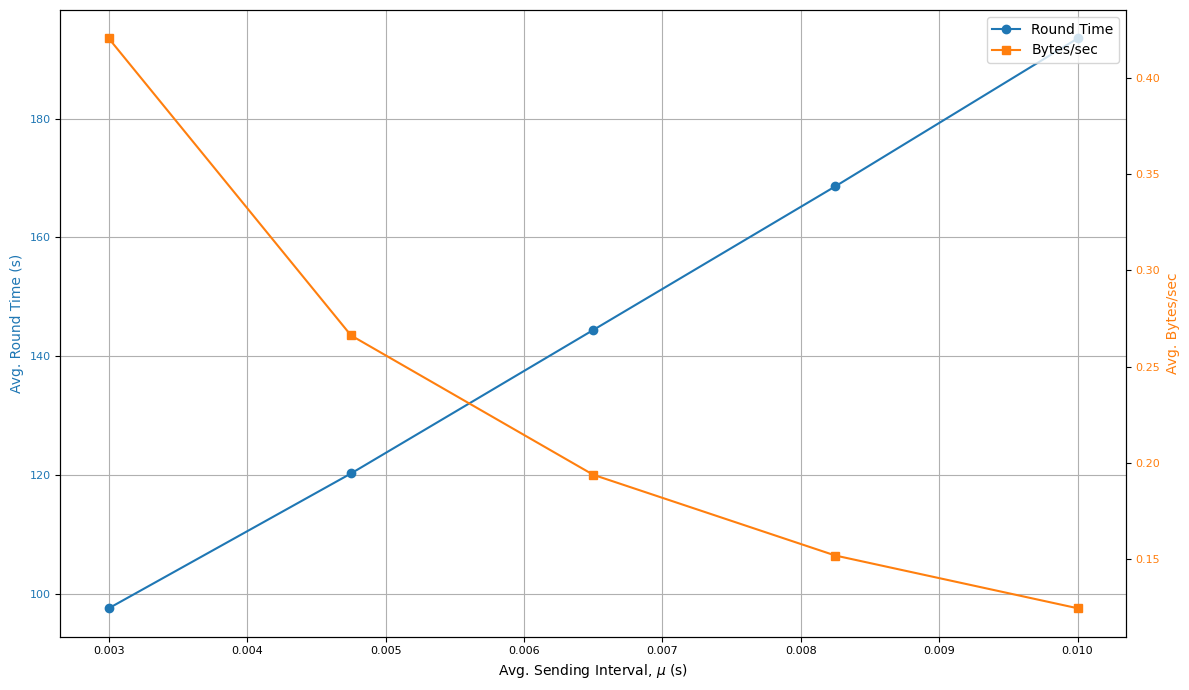

In [2]:
# Time per scenario
# 10 rounds
# y: time per whole scenario
# x: delay in seconds

mus = np.linspace(0.003, 0.01, num=5)
print(mus)

rt_files = get_filenames_in_folder(join(metrics_path, "run_time"))

def deserizalize_time(str_time):
    return dt.datetime.fromisoformat(str_time)

def get_duration(df):
    filtered_df = df.loc[df['field'] == "round_time"]
    return filtered_df['value'].max()

def get_total_msgbytes(df):
    return df[df['field'] == "total_mbytes_sent"].groupby('node')['value'].max().mean()

df_rt_files = [read_file(f) for f in rt_files]
rt_list = [get_duration(df) for df in df_rt_files]
bytes_list = np.array([get_total_msgbytes(df) for df in df_rt_files])
print(bytes_list)
bytes_s = bytes_list / rt_list
print(bytes_s)
print(len(rt_list))
print(rt_list)

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

# First y-axis: Scenario time
ax1.plot(mus[:len(rt_list)], rt_list, marker='o', color='tab:blue', label='Round Time')
ax1.set_xlabel('Avg. Sending Interval, $\\mu$ (s)')
ax1.set_ylabel('Avg. Round Time (s)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second y-axis: Bytes per second
ax2 = ax1.twinx()
ax2.plot(mus[:len(bytes_s)], bytes_s, marker='s', color='tab:orange', label='Bytes/sec')
ax2.set_ylabel('Avg. Bytes/sec', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add grid only on primary axis
ax1.grid(True)
fig.tight_layout()

# Optional: Add a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Save and show
plt.savefig(join(figure_path, "time-and-bytes-per-scenario.png"))
plt.show()


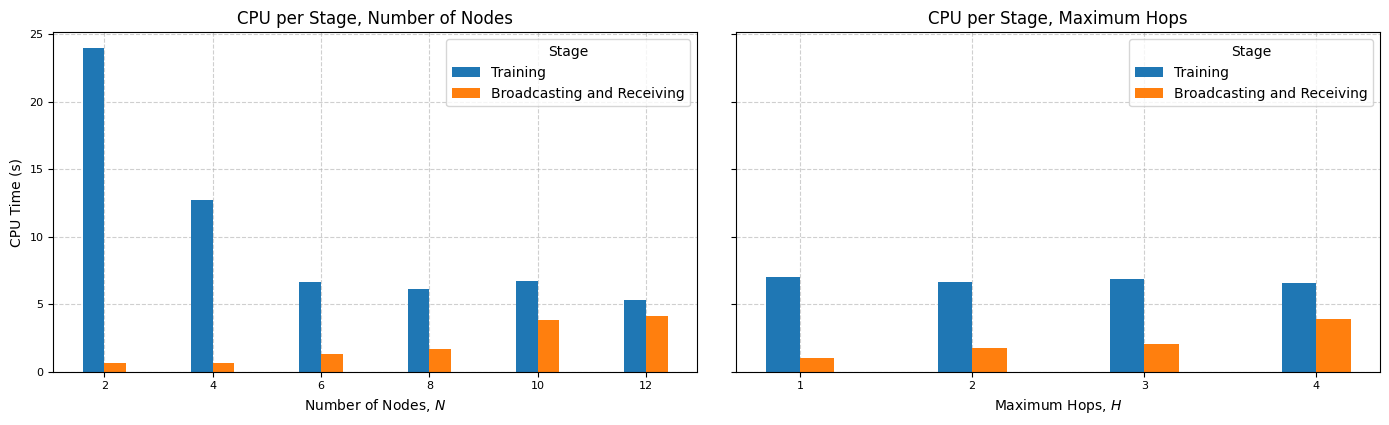

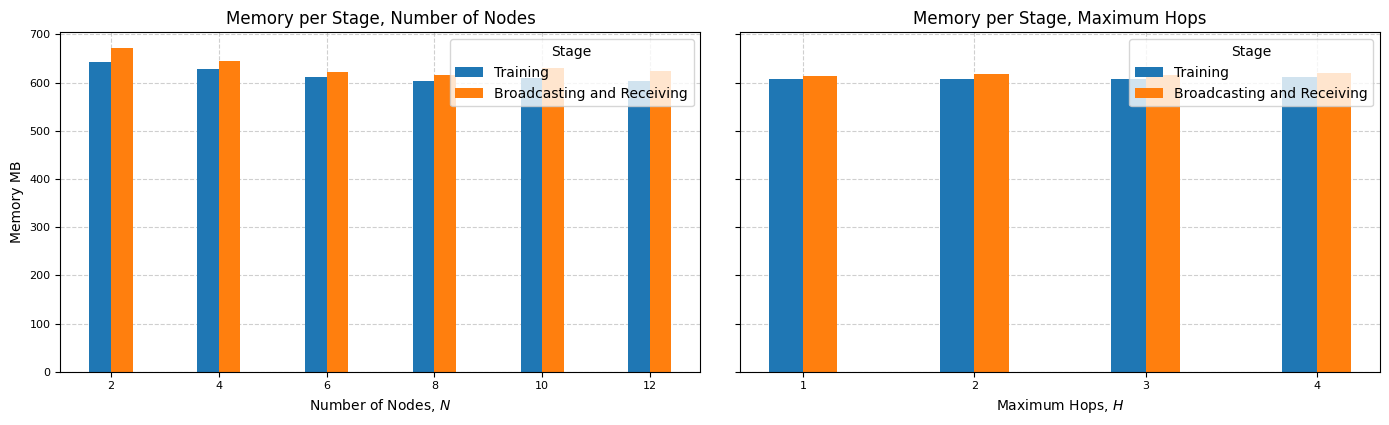

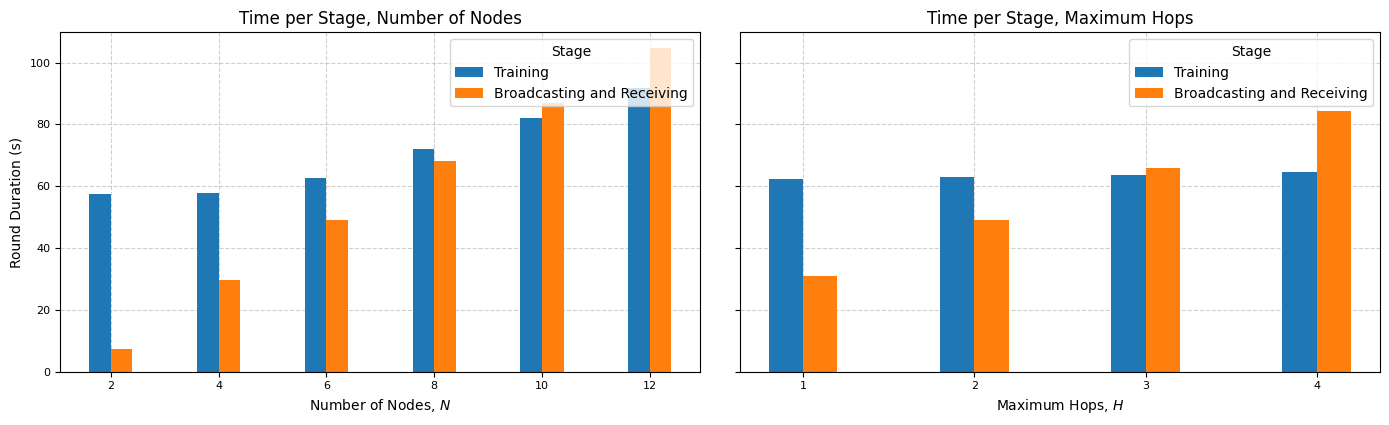

In [19]:
# CPU utilization per state (training, waiting, aggregating, broadcasting)
# y: Total CPU time per stage
# x:
#   - number of nodes       
#   - number of hops        

nr_nodes    = [2, 4, 6, 8, 10, 12]
nr_hops     = [1, 2, 3, 4]
outbox_size = [10 + (i) * 30 for i in range(6)]

stages = {1: "Training", 3: "Broadcasting and Receiving"}

def preprocess_stages(df):
    df = df.copy()
    df.loc[df['stage'] == 2, 'stage'] = 3
    return df

def add_stage_column(df):
    df['stage'] = df.apply(lambda row: row['value'] if row['field'] == 'stage' else None, axis=1)
    df = df.sort_values(['node', 'timestamp'])
    df['stage'] = df.groupby('node')['stage'].ffill()
    df = df[df['stage'].isin([1,2,3])]
    df = preprocess_stages(df)
    return df.sort_values('timestamp')

def get_mem_per_stage(df):
    return (
        df[df['field'] == "memory_mb"]
        .groupby('stage')['value']
        .mean()
    )

def get_cpu_per_stage(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    agg_times = (
        df[df['field'] == 'cpu_total_ns'].groupby(['node', 'stage'])['value']
          .agg(['min', 'max'])
          .reset_index()
    )

    agg_times['delta'] = agg_times['max'] - agg_times['min']

    per_stage_mean = agg_times.groupby('stage')['delta'].mean()

    return per_stage_mean

def get_time_per_stage(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    agg_times = (
        df.groupby(['node', 'stage'])['timestamp']
          .agg(['min', 'max'])
          .reset_index()
    )

    agg_times['delta'] = (agg_times['max'] - agg_times['min']).dt.total_seconds()

    per_stage_mean = agg_times.groupby('stage')['delta'].mean()

    return per_stage_mean

def stage_plot(ax, x_axis, title, x_name, folder, y_name, mode="cpu"):
    files = get_filenames_in_folder(join(metrics_path, folder))[:len(x_axis)]
    df_files = [add_stage_column(read_file(f)) for f in files]

    if (mode=="cpu"):
        y_axis = [get_cpu_per_stage(df) for df in df_files]
    elif (mode=="mem"):
        y_axis = [get_mem_per_stage(df) for df in df_files]
    else:
        y_axis = [get_time_per_stage(df) for df in df_files]
    data = np.array(y_axis)

    width = 0.2

    n = min(len(x_axis), len(y_axis))
    data = data[:n]
    x_axis = x_axis[:n]
    x = np.arange(len(x_axis))

    for i, stage in enumerate(stages):
        ax.bar(x + i * width, data[:, i], width=width, label=stages[stage])

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(x_axis)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(title)
    ax.grid(**GRID_STYLE)

    ax.legend(title='Stage', loc='upper right')

# ----------- CPU FIGURE -----------
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

stage_plot(axs[0], nr_nodes, "CPU per Stage, Number of Nodes", "Number of Nodes, $N$", "nr_nodes", "CPU Time (s)")
stage_plot(axs[1], nr_hops[:4], "CPU per Stage, Maximum Hops", "Maximum Hops, $H$", "max_hops", "CPU Time (s)")

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.savefig(join(figure_path, "cpu_per_stage_grid.png"))
axs[1].set_ylabel("")
plt.show()

# ----------- MEMORY FIGURE -----------
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

stage_plot(axs[0], nr_nodes, "Memory per Stage, Number of Nodes", "Number of Nodes, $N$", "nr_nodes", "Memory MB", mode="mem")
stage_plot(axs[1], nr_hops[:4], "Memory per Stage, Maximum Hops", "Maximum Hops, $H$", "max_hops", "Memory MB", mode="mem")

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.savefig(join(figure_path, "memory_per_stage_grid.png"))
axs[1].set_ylabel("")
plt.show()

# ----------- TIME FIGURE -----------
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

stage_plot(axs[0], nr_nodes, "Time per Stage, Number of Nodes", "Number of Nodes, $N$", "nr_nodes", "Round Duration (s)", mode="time")
stage_plot(axs[1], nr_hops[:4], "Time per Stage, Maximum Hops", "Maximum Hops, $H$", "max_hops", "Round Duration (s)", mode="time")

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.savefig(join(figure_path, "time_per_stage_grid.png"))
axs[1].set_ylabel("")
plt.show()

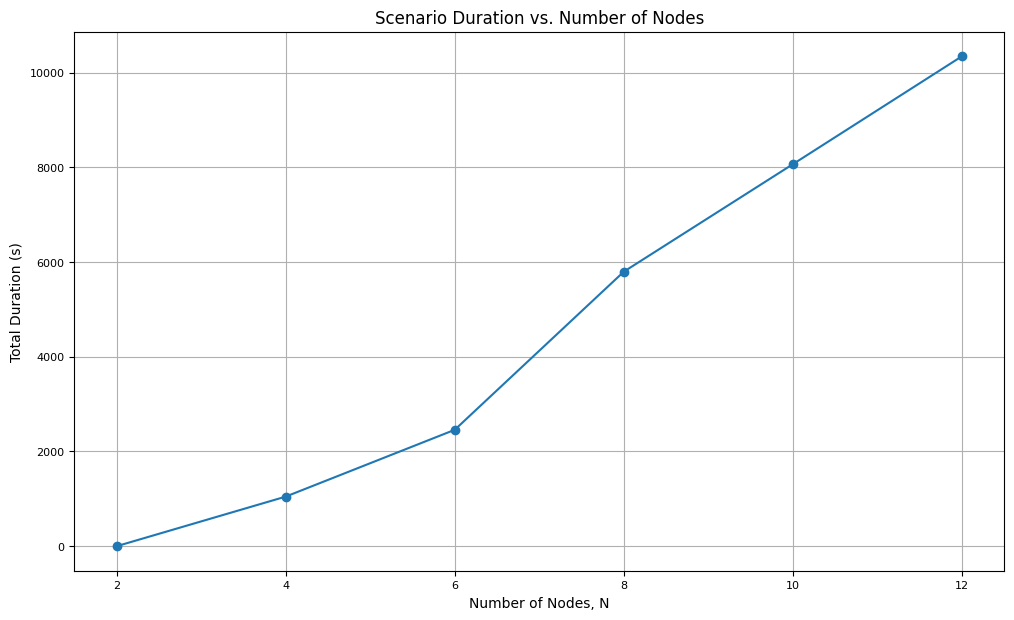

In [14]:
files = get_filenames_in_folder(join(metrics_path, "accuracy"))
df_files = [read_file(f) for f in files]

def get_total_duration(df_files):
    y_axis = []
    for df in df_files:
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

        first_ts_per_value = (
            df[df['field'] == "total_sent"]
            .groupby(['node', 'value'])['timestamp']
            .min()
            .reset_index()
        )

        scenario_end_per_node = first_ts_per_value.groupby('node')['timestamp'].max()
        max_scenario_duration = scenario_end_per_node.max()

        y_axis.append(max_scenario_duration)

    y_axis_seconds = [
        (ts - y_axis[0]).total_seconds() if not pd.isna(ts) else None
        for ts in y_axis
    ]

    return y_axis_seconds


y_axis_nodes = get_total_duration(df_files)

plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.plot(nr_nodes, y_axis_nodes, marker='o')
plt.xlabel("Number of Nodes, N")
plt.ylabel("Total Duration (s)")
plt.title("Scenario Duration vs. Number of Nodes")
plt.grid(True)
plt.show()

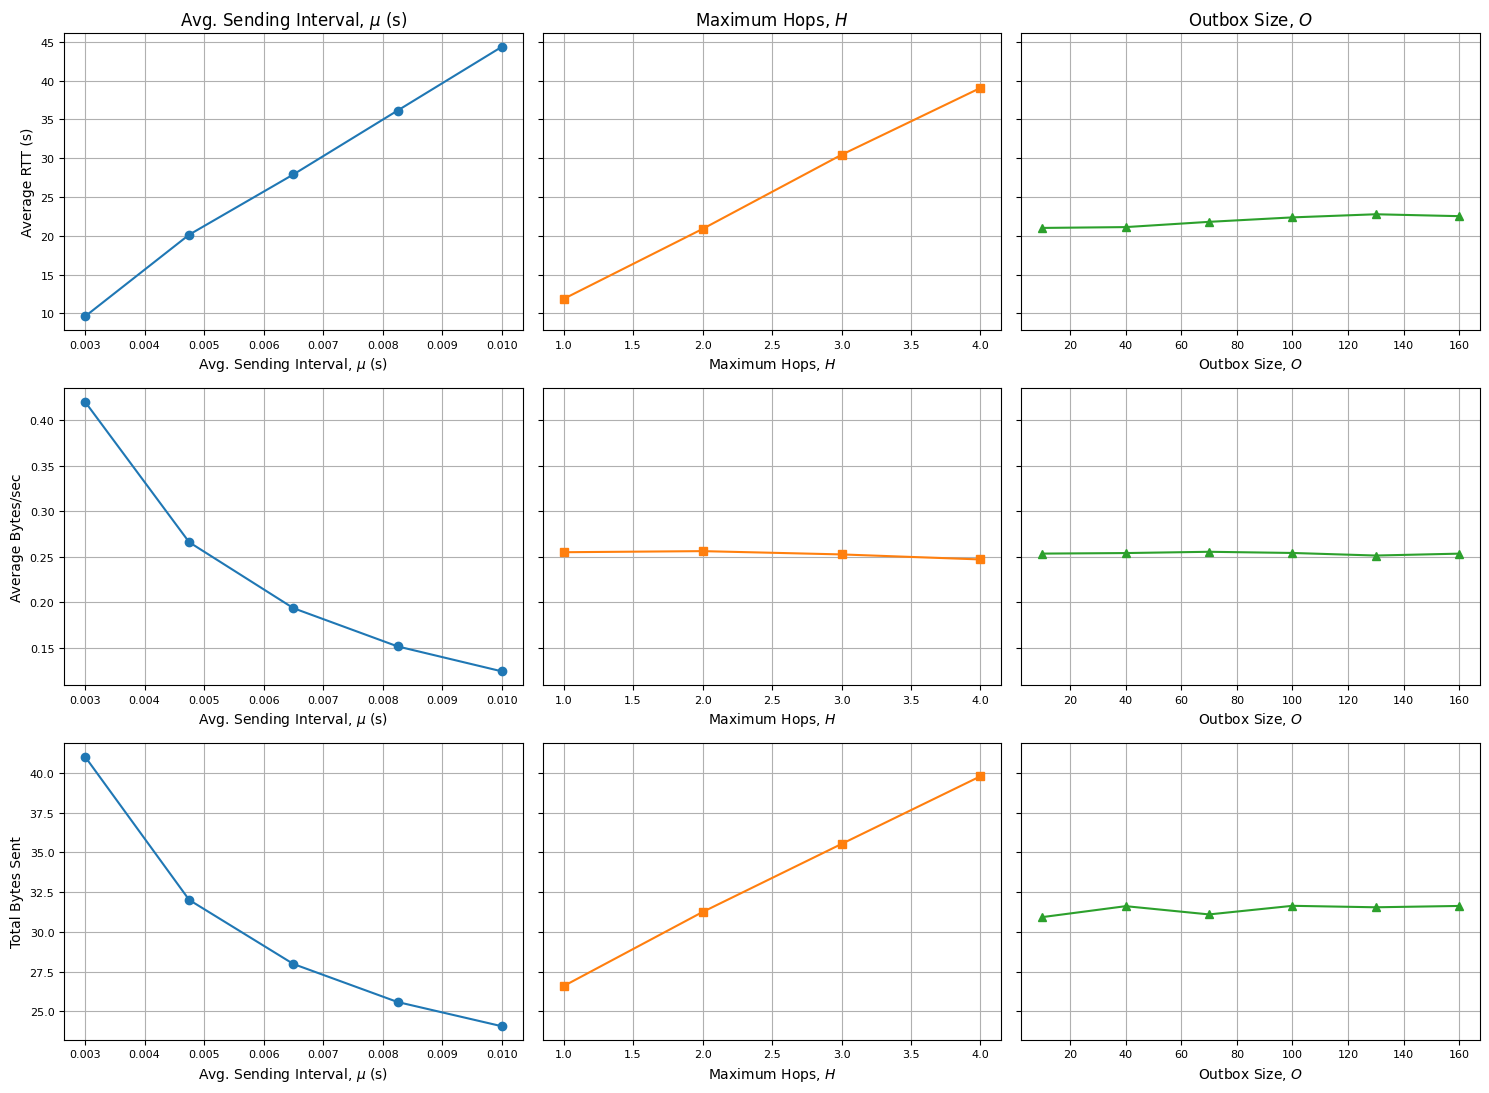

In [ ]:
# y: RTT
# x:
#   - delay in seconds
#   - number of hops

def get_avg_rtt(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    # max_peers = df[df['field'] == "active_peers"]["value"].max()
    # start, end = get_time_interval(df, "active_peers", max_peers)

    # df_interval = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    # df_interval = df
    rtt_per_node = df[(df['field'] == "last_rtt") & (df['value'] != 0)].groupby('node')
    mean_per_node = rtt_per_node['value'].apply(lambda x: x.unique().mean())
    mean = mean_per_node.mean()
    return mean

def plot_combined_rtt_and_bytes_single_figure(x_sets, x_labels, folders):
    fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharey='row')
    markers = ['o', 's', '^']
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    for i, (x_vals, xlabel, folder) in enumerate(zip(x_sets, x_labels, folders)):
        files = get_filenames_in_folder(join(metrics_path, folder))
        df_files = [read_file(f) for f in files]

        y_rtt = [get_avg_rtt(df) for df in df_files]
        rt_list = [get_duration(df) for df in df_files]
        y_total_bytes = np.array([get_total_msgbytes(df) for df in df_files])
        y_bytes_s = y_total_bytes / rt_list

        n = min(len(df_files), len(x_vals))
        x_vals = x_vals[:n]
        y_rtt = y_rtt[:n]
        y_bytes_s = y_bytes_s[:n]
        y_total_bytes = y_total_bytes[:n]

        axs[0, i].plot(x_vals, y_rtt, marker=markers[i], color=colors[i])
        axs[0, i].set_title(xlabel)
        axs[0, i].set_xlabel(xlabel)
        if i == 0:
            axs[0, i].set_ylabel("Average RTT (s)")
        axs[0, i].grid(True)

        axs[1, i].plot(x_vals, y_bytes_s, marker=markers[i], color=colors[i])
        axs[1, i].set_title("")
        axs[1, i].set_xlabel(xlabel)
        if i == 0:
            axs[1, i].set_ylabel("Average Bytes/sec")
        axs[1, i].grid(True)

        axs[2, i].plot(x_vals, y_total_bytes, marker=markers[i], color=colors[i])
        axs[2, i].set_title("")
        axs[2, i].set_xlabel(xlabel)
        if i == 0:
            axs[2, i].set_ylabel("Total Bytes Sent")
        axs[2, i].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(join(figure_path, f"combined_metrics_rtt_bytes.png"))
    plt.show()


x_sets = [mus, nr_hops, outbox_size]
x_labels = ['Avg. Sending Interval, $\\mu$ (s)', "Maximum Hops, $H$", "Outbox Size, $O$"]
folders = ["run_time", "max_hops", "outbox_size"]

plot_combined_rtt_and_bytes_single_figure(x_sets, x_labels, folders)


The output rate of a node is solely determined by the average output rate parameter, therefore the curve is completely flat for max hops and otubox size

Therefore, total bytes increase with maximum hops and it decreases all the same with avg outbox interval, bc it controls the amount of cover traffic.

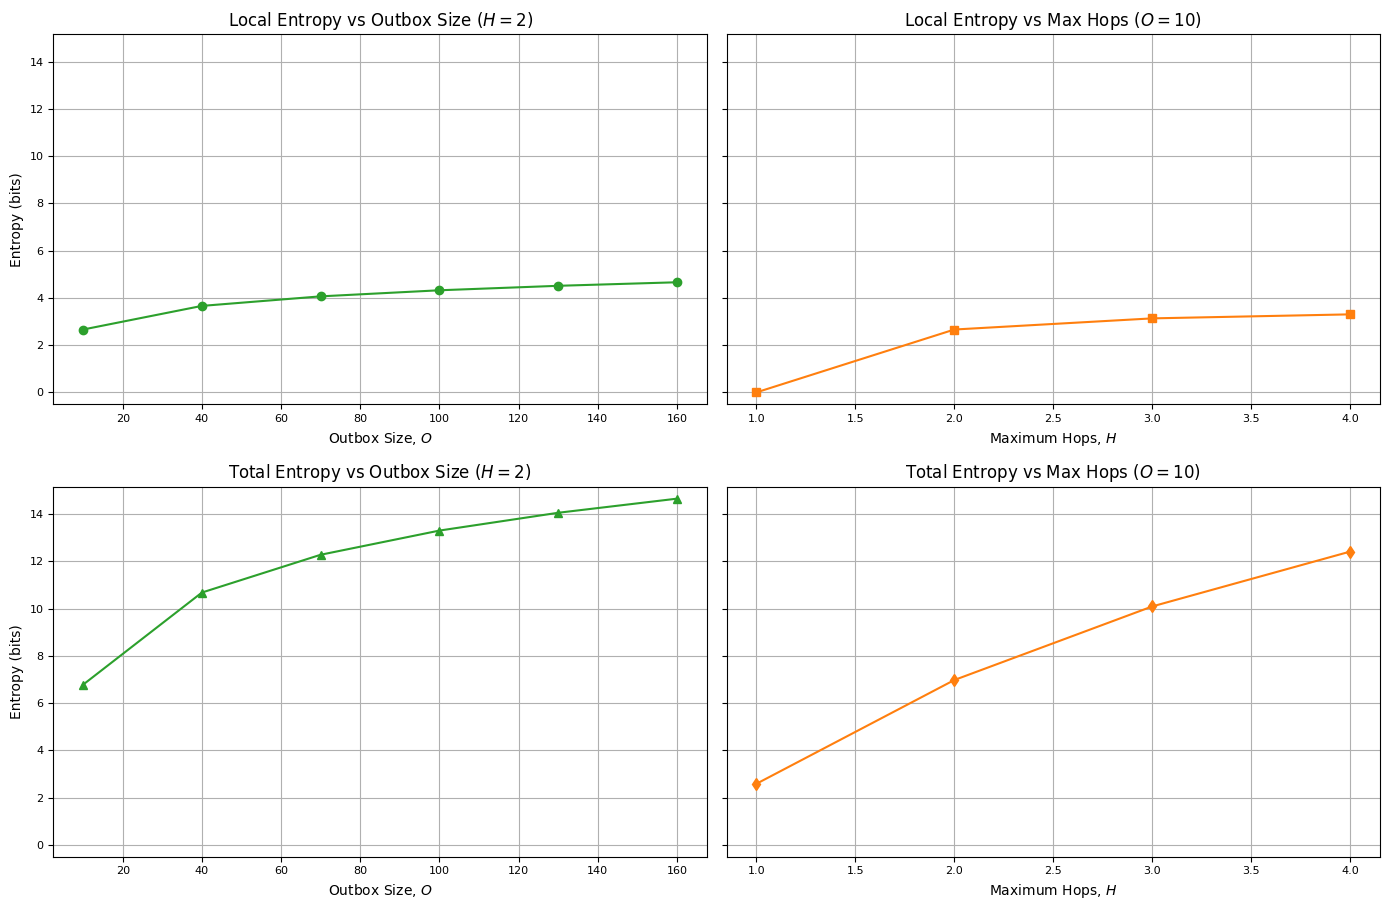

In [4]:
def entropy(probs):
    sum = 0
    for p in probs:
        sum += p * np.log2(p)
    return -sum

# the entropy of matching incoming message to outgoing message in a singular node
def entropy_in_out(outbox_size, max_hops):
    terminated = 1/max_hops
    relayed = 1 - terminated
    relayed_events = [relayed * 1/outbox_size] * outbox_size if relayed != 0 else []
    events = relayed_events + [terminated]
    return entropy(events)

# X e nodes - start node
# tracking a fragment to its recipient
def entropy_recipient(max_hops, nr_nodes):
    n_events = 0
    for hops in range(1, max_hops+1):
        n_per_hops = int(factorial(nr_nodes-1)/factorial(nr_nodes-1-max_hops))
        n_events += n_per_hops
    probs = [1/n_events] * n_events
    return entropy(probs)

def total_path_entropy(outbox_size, max_hops):
    n_events = 0
    for hops in range(1, max_hops+1):
        n_events += outbox_size**hops
    probs = [1/n_events] * n_events
    return entropy(probs)

y_e_io_outbox   = [entropy_in_out(outbox, 2) for outbox in outbox_size]
y_e_io_hops     = [entropy_in_out(10, hops) for hops in nr_hops]
y_e_total_hops    = [total_path_entropy(outbox, 2) for outbox in outbox_size]
y_e_total_nodes   = [total_path_entropy(hops, 6) for hops in nr_hops]

all_vals = y_e_io_outbox + y_e_io_hops + y_e_total_hops + y_e_total_nodes
max_y = max(all_vals) + 0.5
min_y = min(all_vals) - 0.5

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey='row')
axs = axs.flatten()  # makes indexing easier (axs[0] to axs[3])

# Plot 1: entropy_path vs outbox_size (max_hops = 2)
axs[0].plot(outbox_size, y_e_io_outbox, marker='o', color='tab:green')
axs[0].set_title("Local Entropy vs Outbox Size ($H = 2$)")
axs[0].set_xlabel("Outbox Size, $O$")
axs[0].set_ylabel("Entropy (bits)")
axs[0].grid(True)
axs[0].set_ylim(min_y, max_y)

# Plot 2: entropy_path vs max_hops (outbox_size = 10)
axs[1].plot(nr_hops, y_e_io_hops, marker='s', color='tab:orange')
axs[1].set_title("Local Entropy vs Max Hops ($O = 10$)")
axs[1].set_xlabel("Maximum Hops, $H$")
axs[1].grid(True)
axs[1].set_ylim(min_y, max_y)

# Plot 3: entropy_recipient vs nr_nodes (max_hops = 2)
axs[2].plot(outbox_size, y_e_total_hops, marker='^', color='tab:green')
axs[2].set_title("Total Entropy vs Outbox Size ($H = 2$)")
axs[2].set_xlabel("Outbox Size, $O$")
axs[2].set_ylabel("Entropy (bits)")
axs[2].grid(True)
axs[2].set_ylim(min_y, max_y)

# Plot 4: entropy_recipient vs max_hops (nr_nodes = 6)
axs[3].plot(nr_hops, y_e_total_nodes, marker='d', color='tab:orange')
axs[3].set_title("Total Entropy vs Max Hops ($O = 10$)")
axs[3].set_xlabel("Maximum Hops, $H$")
axs[3].grid(True)
axs[3].set_ylim(min_y, max_y)

# Adjust layout and save
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(join(figure_path, "entropy_combined_subplots.png"))
plt.show()


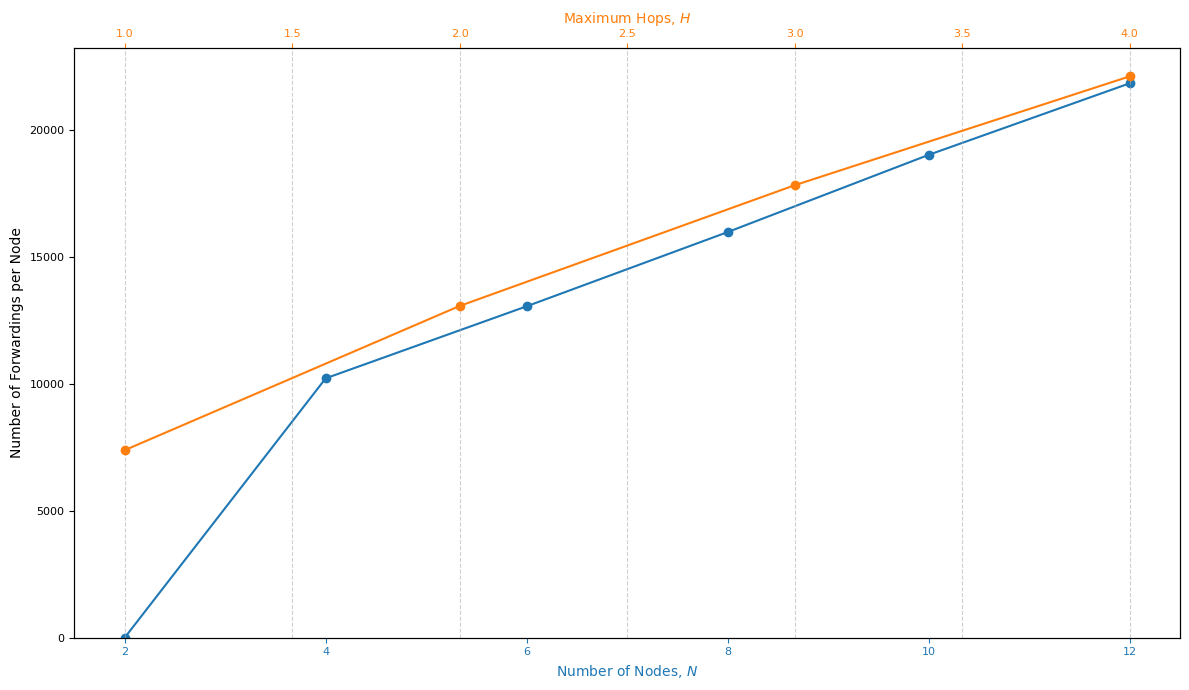

In [ ]:
def get_nr_forwardings(df):
    max_mean = df[df["field"] == "forwarded"].groupby("node")['value'].max().mean()
    return max_mean

def get_y_axis_values(folder):
    files = get_filenames_in_folder(join(metrics_path, folder))
    df_files = [read_file(f) for f in files]
    return [get_nr_forwardings(df) for df in df_files]

def plot_avg_forwardings(x_axis, y_axis, ax, xlabel, color):
    n = min(len(x_axis), len(y_axis))
    x_axis, y_axis = x_axis[:n], y_axis[:n]
    ax.plot(x_axis, y_axis, marker='o', color=color, label=xlabel)
    ax.set_xlabel(xlabel, color=color)
    ax.set_ylabel("# forwardings per node")
    ax.tick_params(axis='x', colors=color)

y_nodes = get_y_axis_values("nr_nodes")
y_hops = get_y_axis_values("max_hops")

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

plot_avg_forwardings(nr_nodes, y_nodes, ax1, "Number of Nodes, $N$", color='tab:blue')
ax1.set_ylabel("Number of Forwardings per Node")
ax1.set_ylim(bottom=0, top=max(max(y_nodes), max(y_hops)) * 1.05)

ax2 = ax1.twiny()
plot_avg_forwardings(nr_hops[:4], y_hops, ax2, "Maximum Hops, $H$", color='tab:orange')

fig.tight_layout()
plt.grid(True, axis='y')
plt.savefig(join(figure_path, "nr_forwardings.png"))
plt.grid(**GRID_STYLE)
plt.show()


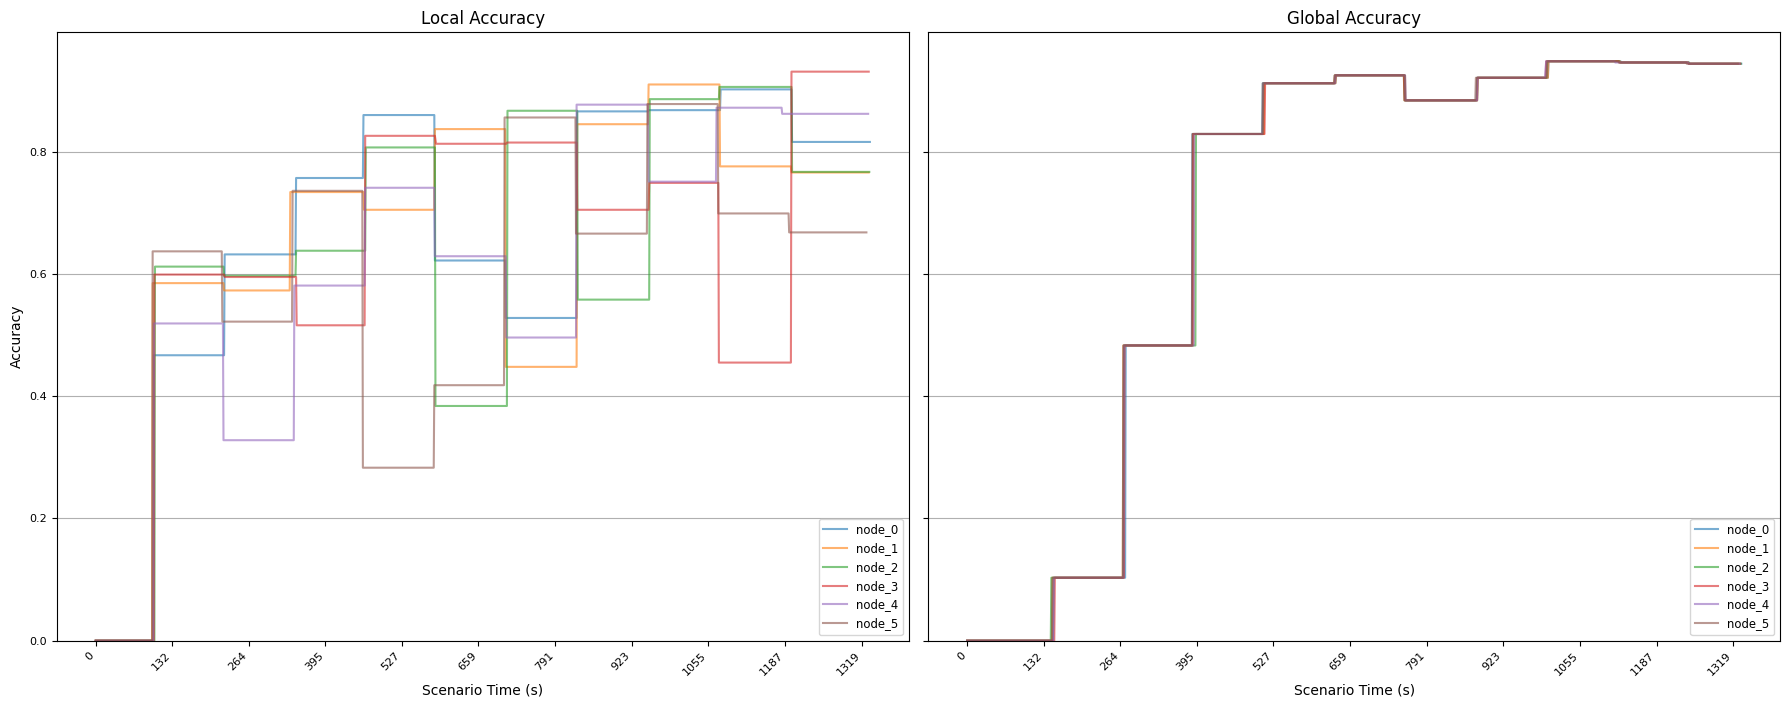

In [6]:
import itertools
def plot_all_nodes_acc_split():
    filename = get_filenames_in_folder(join(metrics_path, "accuracy"))[2]
    df = read_file(filename)

    nodes = df['node'].unique()
    colors = itertools.cycle(plt.cm.tab10.colors)  # cycle through 10 colors

    # Two side-by-side subplots, shared y-axis
    fig, (ax_local, ax_global) = plt.subplots(1, 2, figsize=(FIGURE_SIZE[0] * 1.5, FIGURE_SIZE[1]), sharey=True)

    for node, color in zip(nodes, colors):
        # Extract timestamps for this node
        timestamps = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['timestamp']
        timestamps = pd.to_datetime(timestamps)
        x_axis = (timestamps - timestamps.min()).dt.total_seconds()

        # Extract values
        agg_acc = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['value']
        acc = df[(df['node'] == node) & (df['field'] == 'accuracy')]['value']

        # Plot local accuracy (left subplot)
        ax_local.plot(x_axis, acc, linestyle='-', alpha=0.6, color=color, label=node)

        # Plot global accuracy (right subplot)
        ax_global.plot(x_axis, agg_acc, linestyle='-', alpha=0.6, color=color, label=node)

    # Shared axis labels
    ax_local.set_xlabel("Scenario Time (s)")
    ax_global.set_xlabel("Scenario Time (s)")
    ax_local.set_ylabel("Accuracy")

    # Titles for clarity
    ax_local.set_title("Local Accuracy")
    ax_global.set_title("Global Accuracy")

    # Set y-limit
    ymax = df[df['field'].isin(['aggregated_accuracy', 'accuracy'])]['value'].max()
    ax_local.set_ylim(bottom=0, top=ymax * 1.05)

    # Set consistent x-tick spacing
    step = max(1, len(x_axis) // 10)
    ax_local.set_xticks(x_axis[::step])
    ax_global.set_xticks(x_axis[::step])

    # Legends
    ax_local.legend(loc="lower right", fontsize='small')
    ax_global.legend(loc="lower right", fontsize='small')

    # Layout & save
    fig.tight_layout()
    for ax in (ax_local, ax_global):
        ax.grid(True, axis='y')
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.savefig(join(figure_path, "node_acc_split.png"))
    plt.show()

plot_all_nodes_acc_split()

[0.9495     0.9075     0.80166667 0.819      0.7822     0.7585    ]


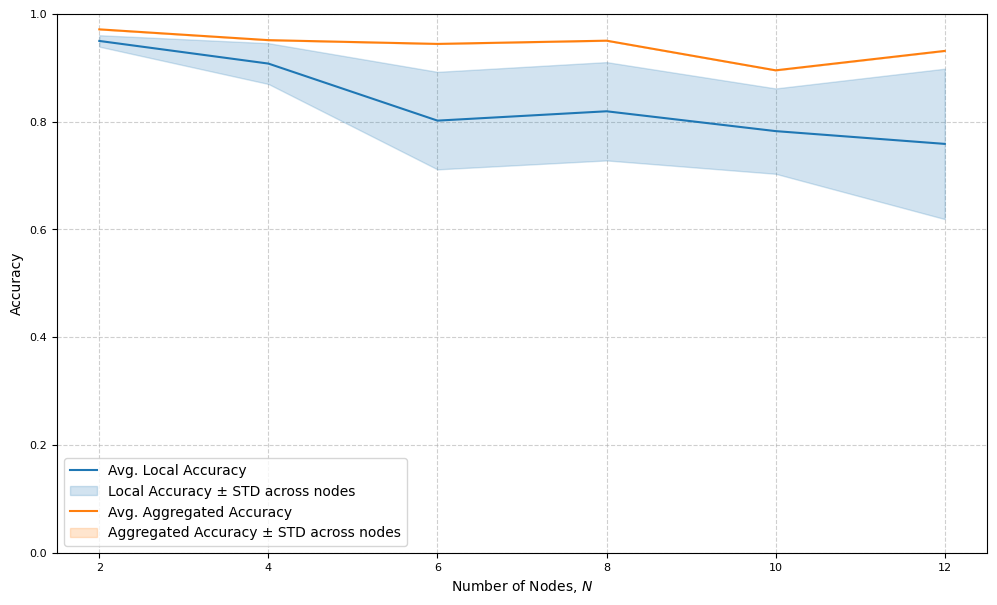

In [ ]:
plt.figure(figsize=FIGURE_SIZE)

files = get_filenames_in_folder(join(metrics_path, "accuracy"))
dfs = [read_file(f) for f in files]

def get_attr_per_node(df, attr):
    return df[df['field'] == attr].groupby('node').tail(1)['value']

local_mean = np.array([get_attr_per_node(df, 'accuracy').mean() for df in dfs])
local_std = np.array([get_attr_per_node(df, 'accuracy').std() for df in dfs])
global_mean = np.array([get_attr_per_node(df, 'aggregated_accuracy').mean() for df in dfs])
global_std = np.array([get_attr_per_node(df, 'aggregated_accuracy').std() for df in dfs])

print(local_mean)

plt.plot(nr_nodes, local_mean, color="tab:blue", label="Avg. Local Accuracy")
plt.fill_between(
    nr_nodes,
    local_mean - local_std,
    local_mean + local_std,
    color="tab:blue",
    alpha=0.2,
    label="Local Accuracy ± STD across nodes"
)

plt.plot(nr_nodes, global_mean, color="tab:orange", label="Avg. Aggregated Accuracy")
plt.fill_between(
    nr_nodes,
    global_mean - global_std,
    global_mean + global_std,
    color="tab:orange",
    alpha=0.2,
    label="Aggregated Accuracy ± STD across nodes"
)

plt.ylim(0, 1)
fig.tight_layout()
plt.ylabel("Accuracy")
plt.xlabel("Number of Nodes, $N$")
plt.legend()
plt.grid(**GRID_STYLE)
plt.savefig(join(figure_path, "accuracy_by_nodes.png"))
plt.show()